# Generating a predictive model of museum visitors

In [137]:
import pandas as pd

import snscrape.modules.twitter as sntwitter

# This is a mess! Need to clean it up
# from datetime import datetime
# import datetime as dt
from datetime import datetime as dt

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Some math stuff
from statistics import mean
import numpy as np

# For wordclouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# For general file handling
import os
import sys

# For data viz
from sklearn.inspection import PartialDependenceDisplay

# Setup the project root directory
PROJ_ROOT = os.path.join(os.pardir)

# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

%aimport src.sentiment

from src.sentiment import clean_tweets

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## debugging

In [154]:
os.getcwd()

'/Users/chad/github/museum_twitter'

In [159]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), 'src') #os.pardir, 'src')
sys.path.append(src_dir)

# import my method from the source code
# %aimport features.build_features
%aimport src.mytest

# from features.build_features import remove_invalid_data

from src.mytest import printme

printme('hello')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
hello is a BAD!!


## tweets

### load tweets

In [60]:
df_tweets = pd.read_csv('data/interim/bristol_tweets_2015_2019.csv')
len(df_tweets), len(df_tweets[df_tweets['Handle']=='@bristolmuseum'])

# Cool way to do it, maybe for later-
# print("There are {} observations and {} features in this dataset. \n".format(df_tweets.shape[0],df_tweets.shape[1]))


(6281, 3113)

### Make a wordcloud

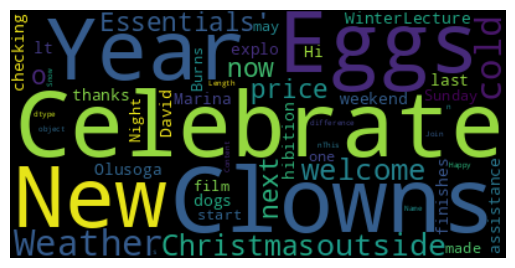

In [61]:
text = str(df_tweets['Content'])
# text = str(df.Content)

text = text.replace('Bristol Museum', '')
# text = re.sub('[Nn]atural|[Mm]useum|[Hh]istory', '', text)
# text = re.sub('[Nn]atural', '', text)
# text = re.sub('[Nn]atural', '', text)

wc = WordCloud().generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

plt.savefig('figs/wordcloud.png', dpi=300, bbox_inches='tight')


## Do sentiment analysis on tweets



In [65]:
df_tweets['Content_cleaned'] = df_tweets['Content'].apply(clean_tweets)
df_tweets.loc[:, ('Content_cleaned','Content')]

,Content_cleaned,Content
0,Weather cold outside welcome warmer Red Lodge,The Weather is cold outside but the welcome is...
1,"'Christmas Essentials' 1/2 price online shop, ...",All 'Christmas Essentials' are now 1/2 price o...
2,next #WinterLecture David Olusoga explores ear...,In our next #WinterLecture David Olusoga explo...
3,*assistance dogs is! ^lt,*assistance dogs that is! ^lt
4,"Hi Marina, thanks checking - however assistanc...","Hi Marina, thanks for checking - however only ..."
...,...,...
6276,Celebrate last weekend Clowns: Eggs-hibition j...,Celebrate the last weekend of Clowns: the Eggs...
6277,clowns eggs-hibition finishes Sunday catch whi...,Our clowns eggs-hibition finishes on Sunday so...
6278,may made one film start & hosted 17 screenings...,I may have only made one film but I did start ...
6279,Celebrate Burns Night difference! Join us nigh...,Celebrate Burns Night with a difference! Join ...


### Now get sentiment

In [66]:
from src.sentiment import get_post_sentiment, get_post_sentiment_value

df_tweets['Sentiment'] = df_tweets['Content_cleaned'].apply(get_post_sentiment)
df_tweets['Sentiment_value'] = df_tweets['Content_cleaned'].apply(get_post_sentiment_value)
df_tweets.head()

# save output
# tweets.to_csv('data/processed/FieldMuseum_2023-03-25_2024-09-11.csv', index=False)

,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,Content_cleaned,Sentiment,Sentiment_value
0,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-30T09:05:08.000Z,False,The Weather is cold outside but the welcome is...,0,3,7,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94703078324...,tweet_id:947030783243497472,Weather cold outside welcome warmer Red Lodge,positive,0.05
1,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-29T09:00:44.000Z,False,All 'Christmas Essentials' are now 1/2 price o...,1,2,5,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94666729063...,tweet_id:946667290631770112,"'Christmas Essentials' 1/2 price online shop, ...",neutral,0.00
2,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T16:00:55.000Z,False,In our next #WinterLecture David Olusoga explo...,0,0,8,0,['#WinterLecture'],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94641064325...,tweet_id:946410643258822656,next #WinterLecture David Olusoga explores ear...,positive,0.12
3,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:57:31.000Z,False,*assistance dogs that is! ^lt,0,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637958779...,tweet_id:946379587793096705,*assistance dogs is! ^lt,neutral,0.00
4,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:56:17.000Z,False,"Hi Marina, thanks for checking - however only ...",2,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637928036...,tweet_id:946379280363159552,"Hi Marina, thanks checking - however assistanc...",positive,0.20


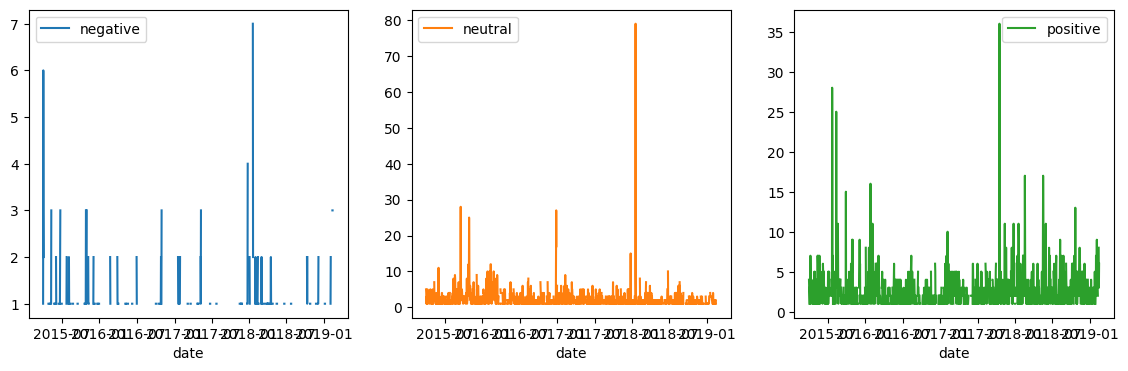

In [67]:
# now plot as a function of time and sentiment:

# Convert timestamp to date
df_tweets['date'] = pd.to_datetime(df_tweets['Timestamp']).dt.date

# Summarize number of rows by date and sentiment
summary_by_date = df_tweets.groupby(['date', 'Sentiment']).size().reset_index(name='counts')

summary_by_date_wide = summary_by_date.pivot(index='date', columns='Sentiment', values='counts')
summary_by_date_wide.reset_index(inplace=True)
summary_by_date_wide.head()

summary_by_date_wide.plot(x='date', y=['negative','neutral','positive'], subplots=True, layout=(1,3), figsize=(14,4))

# Line plot
# sns.lineplot(data=summary_by_date, x='date', y='counts', hue='Sentiment')
# plt.xticks(rotation=45, fontsize=8)

# subplots by sentiment

# Bar plot
# summary_by_date.pivot(index='date', columns='Sentiment', values='counts').plot(kind='bar', stacked=True)
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))

# plt.xticks(rotation=45, fontsize=8)
# plt.title('Number of tweets over time')

# save figure
plt.savefig('figs/timeline_sentiment_bristol.png', dpi=300)

In [68]:
# summary_by_date.sort_values('counts', ascending=False)
df_tweets.groupby(df_tweets['date']).size().sort_values(ascending=False)

date
2018-01-17    90
2017-10-16    40
2015-10-28    34
2017-12-24    30
2015-09-17    29
              ..
2016-10-31     1
2018-07-16     1
2015-05-01     1
2018-01-05     1
2017-03-06     1
Length: 1341, dtype: int64

Composite variables to calculate:

1. public engagement = likes + retweets + tweets
2. public perception = average sentiment value
3. advertisement = number of tweets from @bristolmuseum

In [69]:
# now we can plot the number of tweets and the number of visitors

df_tweets['date'] = pd.to_datetime(df_tweets['Timestamp']).dt.date

# Convert 'Retweets' and 'Likes' to numeric types
df_tweets['Retweets'] = pd.to_numeric(df_tweets['Retweets'], errors='coerce')
df_tweets['Likes'] = pd.to_numeric(df_tweets['Likes'], errors='coerce')

# Summarize total, neutral, positive, and negative tweets by date
tweet_summary_by_date = df_tweets.groupby('date').agg(
    self_counts=('Content', lambda x: sum((df_tweets.loc[x.index, 'Handle'] == '@bristolmuseum'))),
    total_counts=('Content', lambda x: sum((df_tweets.loc[x.index, 'Handle'] != '@bristolmuseum'))),
    likes_counts=('Likes', lambda x: sum(x)),
    retweet_counts=('Retweets', lambda x: sum(x)),
    # avg_sentiment=('Sentiment_value', lambda x: mean(x[tweets.loc[x.index, 'Handle'] != '@bristolmuseum'])),
    neutral_counts=('Sentiment', lambda x: sum((df_tweets.loc[x.index, 'Handle'] != '@bristolmuseum') & (x == 'neutral'))),
    positive_counts=('Sentiment', lambda x: sum((df_tweets.loc[x.index, 'Handle'] != '@bristolmuseum') & (x == 'positive'))),
    negative_counts=('Sentiment', lambda x: sum((df_tweets.loc[x.index, 'Handle'] != '@bristolmuseum') & (x == 'negative')))
).reset_index()

tweet_summary_by_date = tweet_summary_by_date.set_index('date')

tweet_summary_by_date.head()

,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts
date,,,,,,,
2015-04-01,5,5,9.0,11.0,3,2,0
2015-04-02,4,9,22.0,42.0,3,0,6
2015-04-03,2,3,3.0,3.0,0,1,2
2015-04-04,3,2,12.0,5.0,1,0,1
2015-04-05,1,3,5.0,2.0,1,2,0


In [70]:
avg_sent = df_tweets[df_tweets['Handle'] != "@bristolmuseum"].groupby('date').Sentiment_value.mean()
# avg_sentiment=('Sentiment_value', lambda x: mean(x[tweets.loc[x.index, 'Handle'] != '@bristolmuseum'])),

avg_sent = avg_sent.reset_index()
avg_sent = avg_sent.set_index('date')

tweet_summary_by_date = pd.concat([tweet_summary_by_date, avg_sent], axis=1)
tweet_summary_by_date.reset_index(inplace=True)
tweet_summary_by_date



,date,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts,Sentiment_value
0,2015-04-01,5,5,9.0,11.0,3,2,0,0.108333
1,2015-04-02,4,9,22.0,42.0,3,0,6,-0.305556
2,2015-04-03,2,3,3.0,3.0,0,1,2,-0.066667
3,2015-04-04,3,2,12.0,5.0,1,0,1,-0.083333
4,2015-04-05,1,3,5.0,2.0,1,2,0,0.108333
...,...,...,...,...,...,...,...,...,...
1336,2019-02-10,1,5,12.0,4.0,0,3,2,0.256970
1337,2019-02-11,2,3,15.0,9.0,1,0,2,-0.183333
1338,2019-02-12,5,5,134.0,56.0,0,5,0,0.242987
1339,2019-02-13,2,2,38.0,11.0,1,1,0,0.150000


In [71]:
# Ensure the 'date' column is in datetime format
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

# Subset tweets by the specific date
tweets_subset = df_tweets[df_tweets['date'] == pd.to_datetime('2019-02-10')]

# Display the subset
tweets_subset[['Handle', 'date','Sentiment','Sentiment_value','Retweets','Likes']]

,Handle,date,Sentiment,Sentiment_value,Retweets,Likes
6115,@cathmci,2019-02-10,positive,0.466667,0.0,1.0
6116,@bristolmuseum,2019-02-10,negative,-0.550000,2.0,6.0
6117,@sqwzl,2019-02-10,negative,-0.066667,0.0,0.0
6118,@maykithappen,2019-02-10,positive,0.416667,2.0,5.0
6119,@sqwzl,2019-02-10,negative,-0.031818,0.0,0.0
6120,@sqwzl,2019-02-10,positive,0.500000,0.0,0.0


In [72]:
# Pivot the summary_by_month DataFrame

df_tweets['date'] = pd.to_datetime(df_tweets['date'])

# Summarize counts by month
df_tweets['month'] = df_tweets['date'].dt.to_period('M')
summary_by_month = df_tweets.groupby([df_tweets['month'], 'Sentiment']).size().reset_index(name='counts')
summary_by_month_wide = summary_by_month.pivot(index='month', columns='Sentiment', values='counts').fillna(0)

summary_by_month_wide.head()


Sentiment,negative,neutral,positive
month,,,
2015-04,21,70,70
2015-05,19,55,73
2015-06,19,52,62
2015-07,9,46,109
2015-08,10,87,98


OK so the big spike in negative tweets in October 2015 is due to the Death Exhibit at the museum. This is a good example of how sentiment analysis can be misleading.

In [73]:
# Summarize number of posts by month and filter by negative sentiment
summary_by_month_negative = summary_by_month[summary_by_month['Sentiment'] == 'negative']

# Sort by decreasing counts
summary_by_month_negative_sorted = summary_by_month_negative.sort_values(by='counts', ascending=False)

summary_by_month_negative_sorted.head(10)

,month,Sentiment,counts
0,2015-04,negative,21
99,2018-01,negative,20
54,2016-10,negative,19
6,2015-06,negative,19
3,2015-05,negative,19
18,2015-10,negative,18
108,2018-04,negative,14
126,2018-10,negative,13
105,2018-03,negative,13
30,2016-02,negative,13


In [74]:
# Sort by decreasing counts
summary_by_month_positive = summary_by_month[summary_by_month['Sentiment'] == 'positive']
summary_by_month_positive_sorted = summary_by_month_positive.sort_values(by='counts', ascending=False)

summary_by_month_positive_sorted.head(10)

,month,Sentiment,counts
113,2018-05,positive,118
92,2017-10,positive,111
11,2015-07,positive,109
29,2016-01,positive,109
32,2016-02,positive,99
14,2015-08,positive,98
128,2018-10,positive,97
122,2018-08,positive,97
104,2018-02,positive,95
20,2015-10,positive,94


### Top-10 most "negative" posts

In [75]:
import textwrap

neg_tweets = df_tweets[(df_tweets['Sentiment'] == 'negative') & (df_tweets['Handle'] != '@bristolmuseum')]
bot10 = neg_tweets.sort_values(by='Sentiment_value', ascending=True).head(10)
bot10 = list(bot10['Content'])

# Wrap the text and add new lines
bot10 = [textwrap.fill(post, width=100) for post in bot10]

print("\n\n".join(bot10))


 's Grim Reaper finds permanent home at a Bristol museum:
http://itv.com/news/west/update/2015-06-01/banksys-grim-reaper-has-permanent-home-at-museum/…
#bristol #Banksy

A mad hatter party on Friday night! — at Bristol Museum & Art Gallery
https://facebook.com/282008561836671/posts/1935427746494736/…

It's the year of the Dog and you'd be barking mad to miss celebrations Bristol Museum!
https://fb.me/90x74UR6u

#Bath #Job Engagement Officers x 3 - Bristol Museum and Art Gallery - Bristol: (DBS) enhanced
disclosure check... http://tinyurl.com/orplyk8

#Bristol #Job Engagement Officers x 3 - Bristol Museum and Art Gallery - Bristol: (DBS) enhanced
disclos... http://tinyurl.com/oo2bmjo #Jobs

 if I can get a ticket im tempted to go on a road trip! I think I queued for about 5/6 hours for
bankys v Bristol museum :(

#Job #Bath Engagement Officers x 3 - Bristol Museum and Art Gallery - Bristol: (DBS) enhanced
disclosure check... http://tinyurl.com/orplyk8

KUTV 2News Family recalls painful 

NB: many of these aren't really negative. Most are about the Death: The Human Experience exhibit. I might want to think about training my own word2vec kinda model for predicting sentiments.

### Top-10 most positive posts

In [76]:
import textwrap

# Get the top-10 most positive posts
pos_tweets = df_tweets[(df_tweets['Sentiment'] == 'positive') & (df_tweets['Handle'] != "@bristolmuseum")]
top10 = pos_tweets.sort_values(by='Sentiment_value', ascending=True).head(10)
top10 = list(top10['Content'])

# Wrap the text and add new lines
top10 = [textwrap.fill(post, width=100) for post in top10]

print("\n\n".join(top10))


Cheeky little #Banksy in #bristol museum. I was really there seeing Shaun the sheep, but y'know.
http://bit.ly/1OJ5VAQ

It'll be Bassano all the way in 10 days: Curator Dr Jenny Gashke and I share the excitement of
having Leandro's painting back again at Bristol Museum while I link its theme to 'The Eyes that
Look', a novel on another extraordinary Bassano painting, one with an unexplained past.

Did you know Bristol Museum holds 1.7 mil artifacts - around the same as the V&A? 2,100 are from
China. Thanks for sharing a few from the China collection Kate Newnham, Senior Curator, Visual Arts
past, present and future  Pow Wow with

Tomorrow it's Mexican Day of the Dead at Bristol Museum & Art Gallery!  Lots of kid-friendly fun
including... http://fb.me/1FpIuWpuP

This Sunday it's Mexican Day of the Dead at Bristol Museum & Art Gallery!  Lots of kid-friendly fun
including... http://fb.me/MIXlTb8B

Next session - social mobility and inequality #economicsfest @ At- Bristol Museum
https://ins

I want to check this out more closely. Some of these tweets are NOT positive.

## Load the daily visitor data

In [80]:
dt.now()

datetime.datetime(2024, 10, 10, 18, 17, 24, 45861)

{'ROMAN-VILLA', 'Blaise Castle House Museum', 'Bristol Museum', 'Bristol Archives', 'The Red Lodge Museum', 'M Shed', 'The Georgian House Museum'}


<Axes: xlabel='Date'>

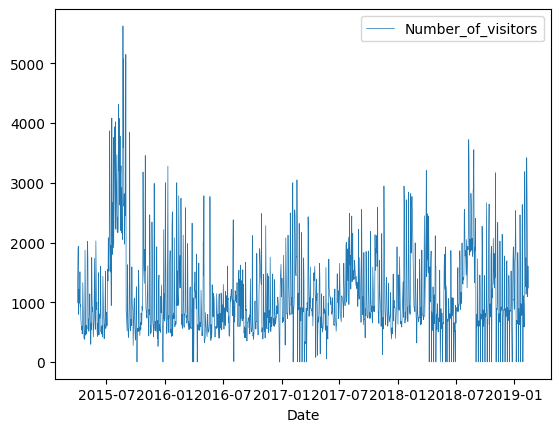

In [81]:
# loading museum visitor data - bristol museum
# https://opendata.bristol.gov.uk/datasets/98d95d36536343eca59e6e4bb04c58b7_0/explore

# Load the data
df_vis = pd.read_csv('data/raw/bristol_visitors.csv')

# Show unique values in the 'Museum' column
print(set(df_vis['Museum']))

# Filter the data to only include the Bristol Museum
df_vis = df_vis[df_vis['Museum'] == 'Bristol Museum']

# Convert the 'Date' column to datetime format and sort
df_vis['Date'] = pd.to_datetime(df_vis['Date']).dt.date
df_vis['year'] = pd.to_datetime(df_vis['Date']).dt.year
df_vis.sort_values('Date', inplace=True)

# Plot the number of visitors over time
df_vis.plot('Date', 'Number_of_visitors', lw=0.5, kind='line')



In [ ]:

# Change figure width
plt.gcf().set_size_inches(10, 6)

# Set tight margins
plt.margins(0.02)

# Shade alternating years
for year in range(df_vis.year.min(), df_vis.year.max() + 1, 2):
    plt.axvspan(dt.date(year, 1, 1), dt.date(year, 12, 31), color='gray', alpha=0.1)

plt.xlim(df_vis['Date'].min(), df_vis['Date'].max())

plt.savefig('figs/visitors_bristol.png', dpi=300)

print('There are on average ', mean(df_vis['Number_of_visitors']), ' visitors per day')

df_vis.Number_of_visitors.groupby(df_vis['year']).sum()


## merge visitor data and tweets

In [110]:
# Merge with visitor data
merged_data = pd.merge(df_vis, tweet_summary_by_date, left_on='Date', right_on='date', how='left')
merged_data['date'] = pd.to_datetime(merged_data['Date'])
merged_data['day'] = merged_data['date'].dt.day_name()
merged_data['weekend'] = [True if x in ['Saturday', 'Sunday'] else False for x in merged_data['day']]
merged_data.head()

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,year,date,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts,Sentiment_value,day,weekend
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015,2015-04-01,5.0,5.0,9.0,11.0,3.0,2.0,0.0,0.108333,Wednesday,False
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015,2015-04-02,4.0,9.0,22.0,42.0,3.0,0.0,6.0,-0.305556,Thursday,False
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015,2015-04-03,2.0,3.0,3.0,3.0,0.0,1.0,2.0,-0.066667,Friday,False
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015,2015-04-04,3.0,2.0,12.0,5.0,1.0,0.0,1.0,-0.083333,Saturday,True
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015,2015-04-05,1.0,3.0,5.0,2.0,1.0,2.0,0.0,0.108333,Sunday,True


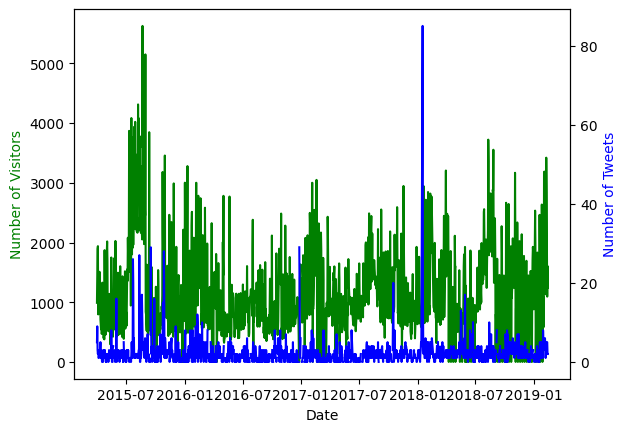

In [86]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data['Date'], merged_data['Number_of_visitors'], 'g-')
ax2.plot(merged_data['Date'], merged_data['total_counts'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Number of Tweets', color='b')

plt.show()

# spikey- are those weekends?



In [87]:
print(merged_data.total_counts.sum()) # should be ~3000
print(len(df_tweets)) # should be 6281

3077.0
6281


In [115]:
# See what's causing the big spike in Jan. 2018
merged_data.sort_values('total_counts', ascending=False)
# merged_data.head()

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,year,date,self_counts,total_counts,likes_counts,retweet_counts,neutral_counts,positive_counts,negative_counts,Sentiment_value,day,weekend
993,Bristol Museum,visits,1342.0,2018-01-17,the counter stopped at 4pm,2018/01/20 14:48:26.611+00,1408,2018,2018-01-17,5.0,85.0,155.0,47.0,77.0,8.0,0.0,0.034916,Wednesday,False
167,Bristol Museum,visits,607.0,2015-09-17,NaN,2017/05/10 14:50:56.010+00,5842,2015,2015-09-17,0.0,29.0,25.0,25.0,28.0,0.0,1.0,-0.017241,Thursday,False
634,Bristol Museum,visits,0.0,2016-12-26,NaN,2017/05/10 14:50:57.757+00,2839,2016,2016-12-26,0.0,29.0,3.0,9.0,27.0,2.0,0.0,0.031034,Monday,False
208,Bristol Museum,visits,1315.0,2015-10-28,NaN,2017/05/10 14:50:56.163+00,5760,2015,2015-10-28,6.0,28.0,26.0,14.0,21.0,7.0,0.0,0.153571,Wednesday,False
131,Bristol Museum,visits,2627.0,2015-08-12,NaN,2017/05/10 14:50:55.875+00,6154,2015,2015-08-12,1.0,27.0,8.0,4.0,2.0,24.0,1.0,0.439352,Wednesday,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,Bristol Museum,visits,693.0,2018-12-13,NaN,2018/12/14 11:08:15.629+00,249,2018,2018-12-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday,False
1334,Bristol Museum,visits,1036.0,2018-12-31,md,2019/02/12 12:17:40.926+00,190,2018,2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday,False
1335,Bristol Museum,visits,1048.0,2018-12-31,NaN,2019/01/06 14:37:14.438+00,189,2018,2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday,False
1342,Bristol Museum,visits,0.0,2019-01-07,NaN,2019/02/12 12:22:44.769+00,174,2019,2019-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday,False


In [116]:
# tweets[tweets['date'] == '2018-01-17']
# tweets

merged_data.to_csv('data/processed/bristol_final_merged.csv', index=False)

# TODO: maybe start the script here, and put all the stuff above into a processing py script

In [118]:
merged_data = pd.read_csv('data/processed/bristol_final_merged.csv')

start_date = dt.strptime('2018-01-17', '%Y-%m-%d').date()
end_date = dt.strptime('2018-01-17', '%Y-%m-%d').date()
# end_date = '2018-01-31'

# TODO: fix this part
# filtered_tweets = tweets[(tweets['date'] >= start_date) & (tweets['date'] <= end_date)]

df_tweets.head()
# Seems that the museum sold a Banksy print without that rights and that caused the spike in tweets that day
# set(filtered_tweets['Content'])

# tweets['date']



,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,Content_cleaned,Sentiment,Sentiment_value,date,month
0,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-30T09:05:08.000Z,False,The Weather is cold outside but the welcome is...,0,3.0,7.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94703078324...,tweet_id:947030783243497472,Weather cold outside welcome warmer Red Lodge,positive,0.05,2017-12-30,2017-12
1,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-29T09:00:44.000Z,False,All 'Christmas Essentials' are now 1/2 price o...,1,2.0,5.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94666729063...,tweet_id:946667290631770112,"'Christmas Essentials' 1/2 price online shop, ...",neutral,0.00,2017-12-29,2017-12
2,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T16:00:55.000Z,False,In our next #WinterLecture David Olusoga explo...,0,0.0,8.0,0,['#WinterLecture'],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94641064325...,tweet_id:946410643258822656,next #WinterLecture David Olusoga explores ear...,positive,0.12,2017-12-28,2017-12
3,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:57:31.000Z,False,*assistance dogs that is! ^lt,0,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637958779...,tweet_id:946379587793096705,*assistance dogs is! ^lt,neutral,0.00,2017-12-28,2017-12
4,Bristol Museum & Art Gallery,@bristolmuseum,2017-12-28T13:56:17.000Z,False,"Hi Marina, thanks for checking - however only ...",2,0.0,0.0,0,[],[],[],https://pbs.twimg.com/profile_images/164072706...,https://x.com/bristolmuseum/status/94637928036...,tweet_id:946379280363159552,"Hi Marina, thanks checking - however assistanc...",positive,0.20,2017-12-28,2017-12


## Weather data

,datetime,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,2014-01-01,2014-01-01,7.9,4.5,10.5,5.8,NaN,176.0,24.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-02,2014-01-02,7.3,4.9,9.3,17.5,NaN,202.0,20.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-03,2014-01-03,6.7,5.3,9.7,4.3,NaN,209.0,28.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-04,2014-01-04,5.1,1.9,7.0,10.2,NaN,193.0,11.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-05,2014-01-05,5.2,1.3,12.1,16.5,NaN,184.0,21.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


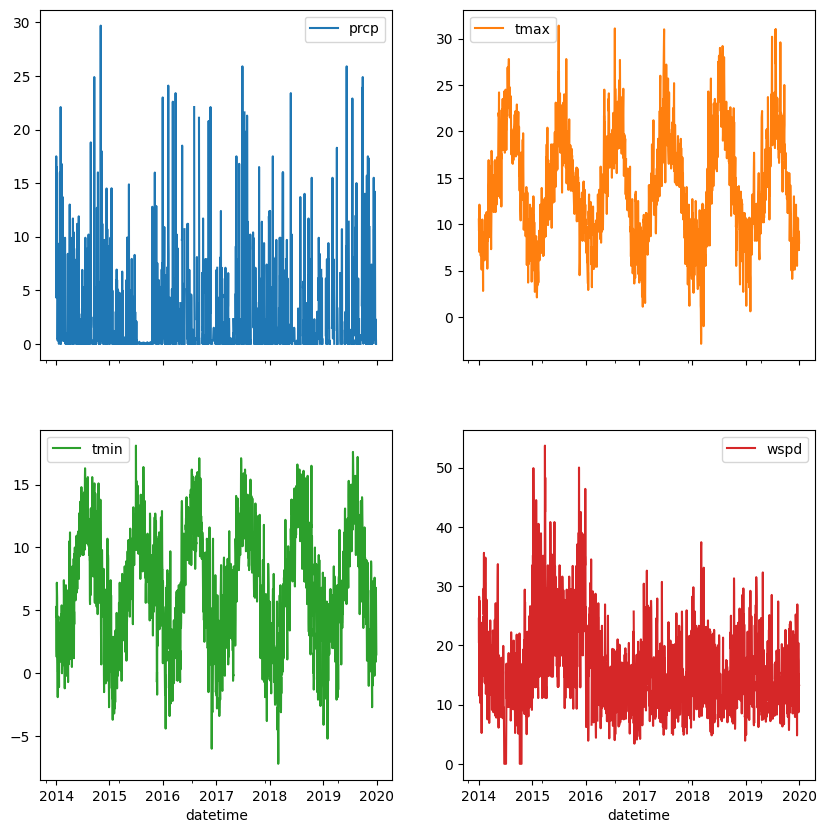

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

df_clim = pd.read_csv('data/raw/meteostat_lyneham.csv')
df_clim['year'] = pd.to_datetime(df_clim['time']).dt.year
df_clim['datetime'] = pd.to_datetime(df_clim['time']).dt.date

# Data from visual crossings
# https://www.visualcrossing.com/weather-history/lyneham/metric/2015-01-01/2015-12-31
# Summer 2015 had lots of NAs for the meteostat data, so here I'm replacing 2015 with this VC data
tmp = pd.read_csv('data/raw/lyneham 2015-01-01 to 2015-12-31.csv')

# Clean up column names
tmp.rename(columns={'tempmax': 'tmax', 'tempmin': 'tmin', 'precip': 'prcp', 'windspeed': 'wspd'}, inplace=True)
tmp['datetime'] = pd.to_datetime(tmp['datetime']).dt.date

# Remove 2015
df_clim = df_clim[df_clim['year'] != 2015]

# Set indices for concatenation
tmp.set_index('datetime', inplace=True)
df_clim.set_index('datetime', inplace=True)

# Concatenate the data
df_clim = pd.concat([df_clim, tmp], ignore_index=False)

# climdat[['tmax', 'tmin', 'prcp', 'wspd']]

df_clim.reset_index(inplace=True)

df_clim = df_clim.sort_values(by='datetime', ascending=True)

df_clim.plot(x='datetime', y=['prcp','tmax','tmin','wspd'], subplots=True, layout=(2,2), figsize=(10,10))

# Ensure all rows increment by 1 day
all_days = pd.date_range(start=df_clim['datetime'].min(), end=df_clim['datetime'].max(), freq='D')
df_clim = df_clim.set_index('datetime').reindex(all_days).rename_axis('datetime').reset_index()

df_clim.head()


    datetime        time  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt  \
0 2014-01-01  2014-01-01   7.9   4.5  10.5   5.8   NaN  176.0  24.5   NaN   
1 2014-01-02  2014-01-02   7.3   4.9   9.3  17.5   NaN  202.0  20.4   NaN   
2 2014-01-03  2014-01-03   6.7   5.3   9.7   4.3   NaN  209.0  28.2   NaN   
3 2014-01-04  2014-01-04   5.1   1.9   7.0  10.2   NaN  193.0  11.5   NaN   
4 2014-01-05  2014-01-05   5.2   1.3  12.1  16.5   NaN  184.0  21.7   NaN   

   ...  solarenergy  uvindex  severerisk sunrise  sunset  moonphase  \
0  ...          NaN      NaN         NaN     NaN     NaN        NaN   
1  ...          NaN      NaN         NaN     NaN     NaN        NaN   
2  ...          NaN      NaN         NaN     NaN     NaN        NaN   
3  ...          NaN      NaN         NaN     NaN     NaN        NaN   
4  ...          NaN      NaN         NaN     NaN     NaN        NaN   

   conditions  description  icon  stations  
0         NaN          NaN   NaN       NaN  
1         NaN       

array([[<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>],
       [<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>]],
      dtype=object)

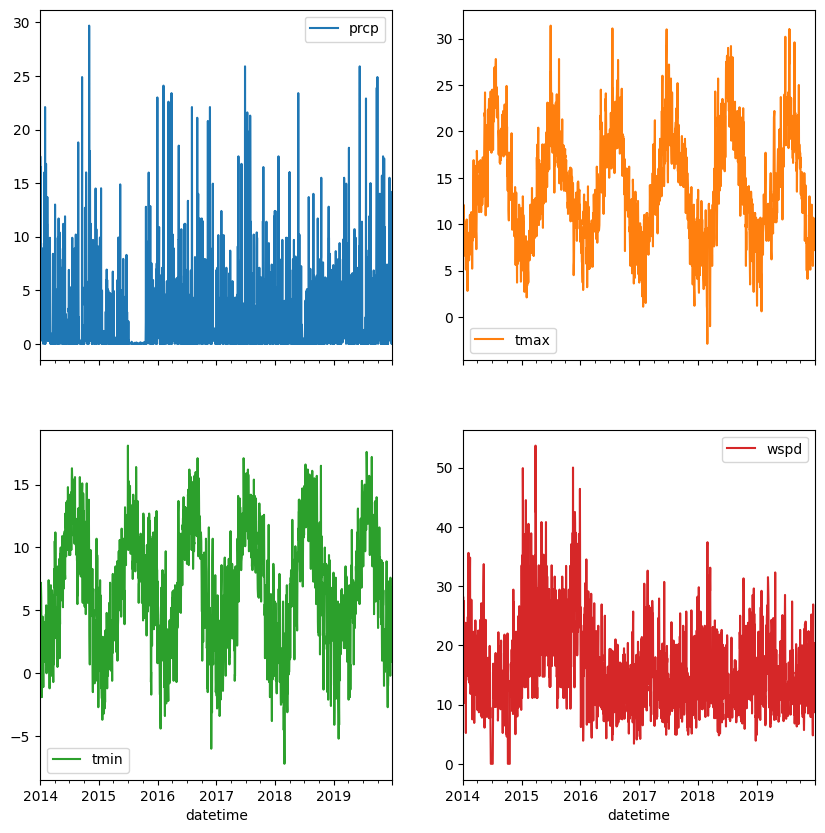

In [10]:
# impute missing precip data

import numpy as np
from sklearn.impute import KNNImputer

nan = np.nan

X = df_clim[['prcp','tmax','tmin','wspd']]

imputer = KNNImputer(n_neighbors=2, weights="uniform")

tmp = imputer.fit_transform(X)

tmp = pd.DataFrame(tmp, columns=['prcp','tmax','tmin','wspd'])

# tmp.head()
# tmp.plot(subplots=True, layout=(2,2), figsize=(10,10))
# array([[1. , 2. , 4. ],
#        [3. , 4. , 3. ],
#        [5.5, 6. , 5. ],
#        [8. , 8. , 7. ]])

# print(len(tmp), len(df_clim))

df_clim[['prcp','tmax','tmin','wspd']] = tmp[['prcp','tmax','tmin','wspd']]

print(df_clim.head())

df_clim.plot(x='datetime', y=['prcp','tmax','tmin','wspd'], subplots=True, layout=(2,2), figsize=(10,10))


In [119]:
# add weather data to the merged data

# Convert 'time' column to datetime
df_clim['Date'] = pd.to_datetime(df_clim['datetime']).dt.date
merged_data['Date'] = pd.to_datetime(merged_data['Date']).dt.date

# Merge weather data with the merged_data DataFrame
merged_data_clim = pd.merge(merged_data, df_clim, left_on='Date', right_on='Date', how='left')
merged_data_clim.head()


,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,year_x,date,self_counts,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015,2015-04-01,5.0,...,13.5,5.0,NaN,2015-04-01T06:44:04,2015-04-01T19:40:36,0.40,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03647099999,03743099999,03746099999,0364409999..."
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015,2015-04-02,4.0,...,7.9,4.0,NaN,2015-04-02T06:41:48,2015-04-02T19:42:17,0.43,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03647099999,03743099999,03746099999,0364409999..."
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015,2015-04-03,2.0,...,8.7,5.0,NaN,2015-04-03T06:39:32,2015-04-03T19:43:57,0.47,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"03647099999,03743099999,03746099999,0364409999..."
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015,2015-04-04,3.0,...,14.1,5.0,NaN,2015-04-04T06:37:17,2015-04-04T19:45:38,0.50,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain,"03743099999,03746099999,03644099999,0364909999..."
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015,2015-04-05,1.0,...,9.1,4.0,NaN,2015-04-05T06:35:02,2015-04-05T19:47:18,0.53,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03743099999,03746099999,03644099999,0364909999..."


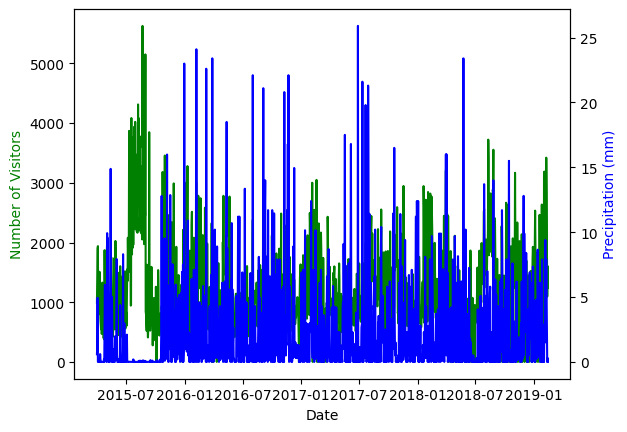

In [120]:
# Plot precipitation and visits
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['Date'], merged_data_clim['prcp'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Precipitation (mm)', color='b')

plt.show()

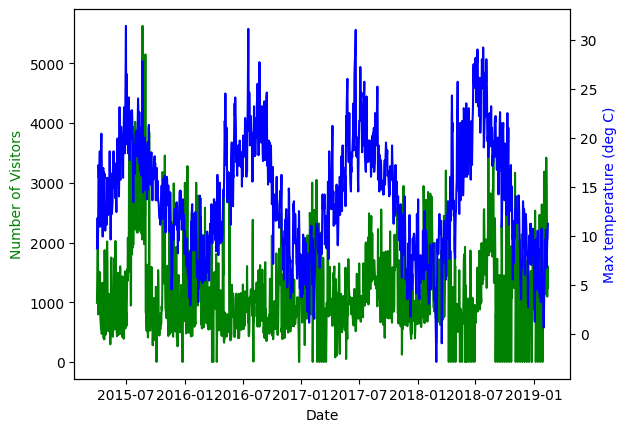

In [121]:
# Plot average temperature and museum visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['Date'], merged_data_clim['tmax'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Max temperature (deg C)', color='b')

plt.show()

Text(0, 0.5, 'Number of twitter likes')

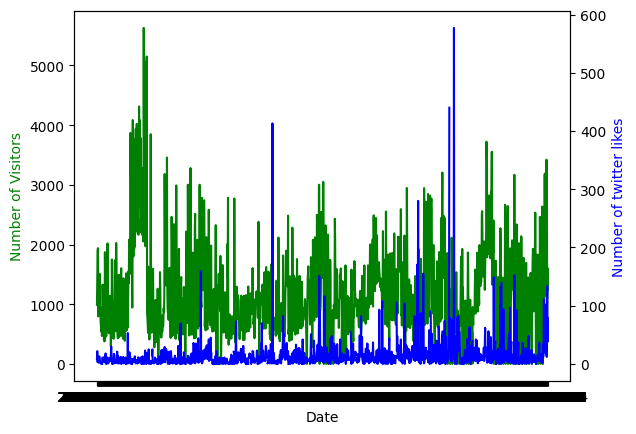

In [122]:
# Plot average temperature and museum visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['date'], merged_data_clim['likes_counts'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Number of twitter likes', color='b')


## Time series decomposition

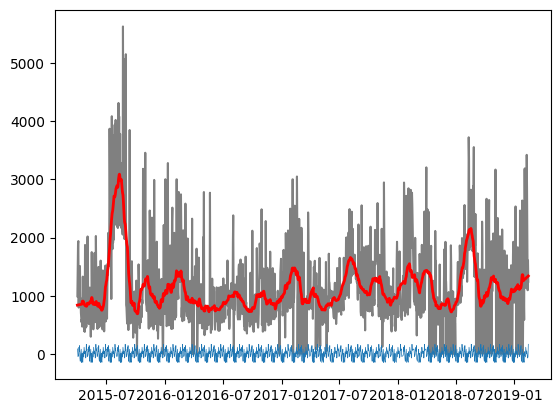

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

# trying this out

xvar = merged_data_clim['Date']
yvar = merged_data_clim['Number_of_visitors']

ts = pd.Series(yvar.values, index=xvar)

plt.plot(ts, color='gray')

results_add = seasonal_decompose(ts, model='additive', filt=None, period=30, two_sided=True, extrapolate_trend=30)

plt.plot(results_add.trend, label='additive trend', color='red', lw=2)
plt.plot(results_add.seasonal, label='seasonal trend', lw=0.5)


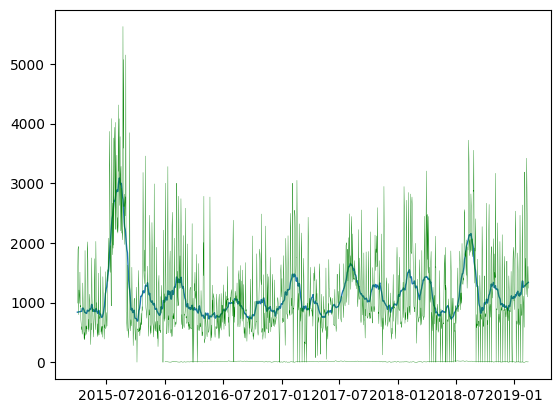

In [124]:
plt.plot(results_add.trend, label='seasonal trend', lw=1)
plt.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-', lw=.25)
plt.plot(merged_data_clim['Date'], merged_data_clim['tavg'], 'g-', lw=.25)

# extract the trend
trend = results_add.trend
trend = trend.dropna()
len(trend)

# Align the trend series with the merged_data_clim DataFrame
merged_data_clim = merged_data_clim.set_index('Date')
merged_data_clim['trend'] = trend
merged_data_clim = merged_data_clim.reset_index()

# merged_data_clim.head()


## Random forest regression modeling

### Setting up all the variables

In [238]:

# what other predictors?
# i want to make a predictive model of future trends 

# what about holidays?

# what about weekends?

# what about school holidays? NOT SURE

# what about special events?

# what about unique exhibitions?
# Create a variable to indicate if dates are within certain ranges
def is_within_date_range(date, start, end):
    return start <= date <= end

# Define the date ranges for the exhibits
exhibit_ranges = [
    ('2015-10-24', '2016-03-01'),  # death: the human experience
    ('2015-07-04', '2015-09-13'),  # art in nature
    ('2015-05-16', '2015-08-31'), # hogmorth
    ('2018-07-07', '2018-09-02')  # woman hour craft prize
    # '2016-04-22' # art from everywhere
    # '2016-05-21' # rembrandt
]

# Convert string dates to datetime.date objects
exhibit_ranges = [(dt.strptime(start, '%Y-%m-%d').date(), dt.strptime(end, '%Y-%m-%d').date()) for start, end in exhibit_ranges]

# Apply the function to create the 'exhibit' column
merged_data_clim['exhibit'] = merged_data_clim['Date'].apply(lambda x: any(is_within_date_range(x, start, end) for start, end in exhibit_ranges))

# what about marketing campaigns?

# what about twitter sentiment? (might need to account for a lag here)
# DONE

# what about the weather?
# DONE

# what about the day of the week?
# DONE


# what about the month?
merged_data_clim['month'] = pd.to_datetime(merged_data_clim['Date']).dt.month

# what about the year?
merged_data_clim['year'] = pd.to_datetime(merged_data_clim['Date']).dt.year

# what about the season?
# winter: December to February
# spring: March to May
# summer: June to August
# autumn: September to November
merged_data_clim['season'] = pd.cut(merged_data_clim['month'], bins=[0, 3, 6, 9, 12], labels=['winter', 'spring', 'summer', 'autumn'])

merged_data_clim['closed'] = [True if x < 10 else False for x in merged_data_clim['Number_of_visitors']]

# merged_data_clim.head()

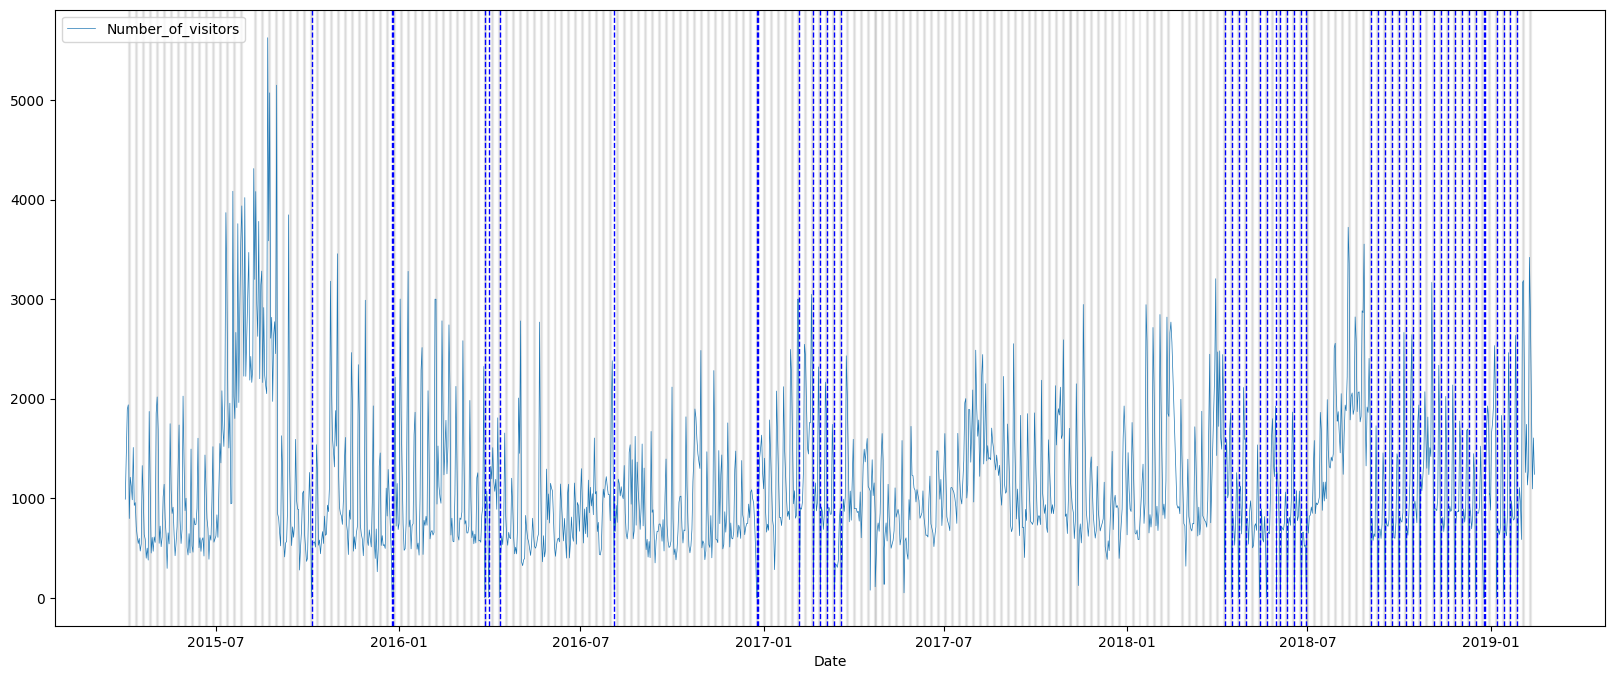

In [239]:
merged_data_clim.plot(x='Date', y='Number_of_visitors', lw=0.5, figsize=(20,8))

# Add vertical lines at events
# for event in events:
#     plt.axvline(pd.to_datetime(event), color='r', linestyle='--', lw=1)

# plt.xlim(pd.to_datetime('2015-10-01'), pd.to_datetime('2016-07-01'))

# Shade the weekends
for i, row in merged_data_clim.iterrows():
    if row['weekend']:
        plt.axvspan(row['Date'], row['Date'] + pd.Timedelta(days=1), color='gray', alpha=0.1)

# Add vertical lines if closed is True
for i, row in merged_data_clim.iterrows():
    if row['closed']:
        plt.axvline(row['Date'], color='blue', linestyle='--', lw=1)

## Exploratory plots

<Axes: xlabel='fourthroot_visitors', ylabel='Count'>

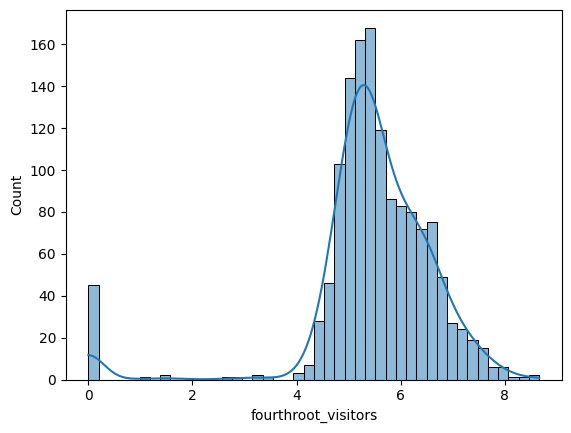

In [127]:
# Check if the number of visitors is roughly normally distributed
# sns.histplot(merged_data_clim['Number_of_visitors'], kde=True)

# log transform the number of visitors
# merged_data_clim['log_visitors'] = np.log(merged_data_clim['Number_of_visitors'])
# pow(2,2)
merged_data_clim['fourthroot_visitors'] = merged_data_clim['Number_of_visitors'].apply(lambda x: pow(x,.25))

sns.histplot(merged_data_clim['fourthroot_visitors'], kde=True)

((array([-3.2891129 , -3.03074295, -2.8869896 , ...,  2.8869896 ,
          3.03074295,  3.2891129 ]),
  array([0.        , 0.        , 0.        , ..., 8.43990612, 8.47174524,
         8.66140851])),
 (np.float64(1.122964290765533),
  np.float64(5.483056213078885),
  np.float64(0.8726851681563494)))

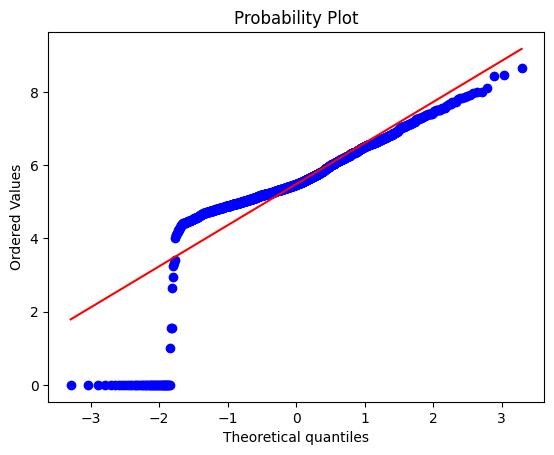

In [128]:
# make a quantiles plot
import scipy.stats as stats
import matplotlib.pyplot as plt
stats.probplot(merged_data_clim['fourthroot_visitors'], dist="norm", plot=plt)

<Axes: xlabel='tmax', ylabel='trend'>

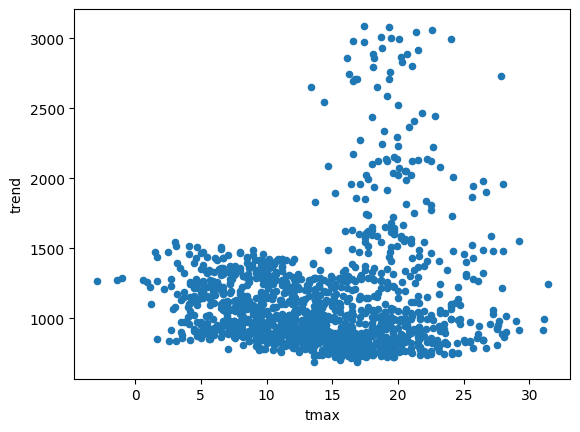

In [129]:
# merged_data_clim.plot(x='tmax', y='Number_of_visitors', kind='scatter')
merged_data_clim.plot(x='tmax', y='trend', kind='scatter')

## Feature engineering

In [432]:
# add a column
merged_data_clim['promotion'] = merged_data_clim['self_counts']
merged_data_clim['engagement'] = merged_data_clim['retweet_counts'] + merged_data_clim['likes_counts'] + merged_data_clim['total_counts']
merged_data_clim.rename(columns={'Sentiment_value': 'sentiment'}, inplace=True)

# create dummy columns for modeling below
df_final = pd.get_dummies(merged_data_clim, columns=['day', 'season', 'year'])

df_final.head()
# get list of columns
# merged_data_clim.columns

,Date,Museum,Kpi,Number_of_visitors,Comments,Date_Logged,ObjectId,year_x,date,self_counts,...,day_Wednesday,season_winter,season_spring,season_summer,season_autumn,year_2015,year_2016,year_2017,year_2018,year_2019
0,2015-04-01,Bristol Museum,visits,990.0,NaN,2017/05/10 14:50:55.376+00,6854,2015,2015-04-01,5.0,...,True,False,True,False,False,True,False,False,False,False
1,2015-04-02,Bristol Museum,visits,1452.0,NaN,2017/05/10 14:50:55.380+00,6848,2015,2015-04-02,4.0,...,False,False,True,False,False,True,False,False,False,False
2,2015-04-03,Bristol Museum,visits,1894.0,NaN,2017/05/10 14:50:55.384+00,6842,2015,2015-04-03,2.0,...,False,False,True,False,False,True,False,False,False,False
3,2015-04-04,Bristol Museum,visits,1939.0,NaN,2017/05/10 14:50:55.387+00,6836,2015,2015-04-04,3.0,...,False,False,True,False,False,True,False,False,False,False
4,2015-04-05,Bristol Museum,visits,796.0,NaN,2017/05/10 14:50:55.391+00,6830,2015,2015-04-05,1.0,...,False,False,True,False,False,True,False,False,False,False


In [433]:
# figure out where there are gaps in days
# merged_data_clim['date'].diff().plot()

df_final.loc[121]

Date                      2015-07-31
Museum                Bristol Museum
Kpi                           visits
Number_of_visitors            2225.0
Comments                         NaN
                           ...      
year_2015                       True
year_2016                      False
year_2017                      False
year_2018                      False
year_2019                      False
Name: 121, Length: 81, dtype: object

### Clean the data set

In [435]:
# Adding lag features

# Daily lag
df_final['vis_lag1'] = df_final['Number_of_visitors'].shift(1)

# df_final['vis_lag2'] = df_final['Number_of_visitors'].shift(2)

# Weekly lag
df_final['vis_lag7'] = df_final['Number_of_visitors'].shift(7)


df_final.head()

,Date,Museum,Kpi,Number_of_visitors,Comments,Date_Logged,ObjectId,year_x,date,self_counts,...,season_summer,season_autumn,year_2015,year_2016,year_2017,year_2018,year_2019,vis_lag1,vis_lag3,vis_lag7
0,2015-04-01,Bristol Museum,visits,990.0,NaN,2017/05/10 14:50:55.376+00,6854,2015,2015-04-01,5.0,...,False,False,True,False,False,False,False,NaN,NaN,NaN
1,2015-04-02,Bristol Museum,visits,1452.0,NaN,2017/05/10 14:50:55.380+00,6848,2015,2015-04-02,4.0,...,False,False,True,False,False,False,False,990.0,NaN,NaN
2,2015-04-03,Bristol Museum,visits,1894.0,NaN,2017/05/10 14:50:55.384+00,6842,2015,2015-04-03,2.0,...,False,False,True,False,False,False,False,1452.0,NaN,NaN
3,2015-04-04,Bristol Museum,visits,1939.0,NaN,2017/05/10 14:50:55.387+00,6836,2015,2015-04-04,3.0,...,False,False,True,False,False,False,False,1894.0,NaN,NaN
4,2015-04-05,Bristol Museum,visits,796.0,NaN,2017/05/10 14:50:55.391+00,6830,2015,2015-04-05,1.0,...,False,False,True,False,False,False,False,1939.0,NaN,NaN


In [436]:
# Select relevant variables

# Full model
selected_columns = ['Date', 'weekend', 'Number_of_visitors', 'exhibit', 'promotion',
                    'sentiment', 'engagement', 'closed', 'prcp', 'tmin', 'tmax', 'wspd',
                    'day_Monday','day_Tuesday','day_Wednesday','day_Thursday','day_Friday',
                    'day_Saturday','day_Sunday', 'season_spring', 'season_summer', 'season_autumn',
                    'season_winter',
                    'vis_lag1', 'vis_lag7']

# No season
selected_columns1 = ['Date', 'weekend', 'Number_of_visitors', 'exhibit', 'promotion',
                    'sentiment', 'engagement', 'closed', 'prcp', 'tmin', 'tmax', 'wspd',
                    'day_Monday','day_Tuesday','day_Wednesday','day_Thursday','day_Friday',
                    'day_Saturday','day_Sunday',
                    'vis_lag1', 'vis_lag7']

# Accounting for year
selected_columns2 = ['Date', 'weekend', 'Number_of_visitors', 'exhibit', 'promotion',
                    'sentiment', 'engagement', 'closed', 'prcp', 'tmin', 'tmax', 'wspd',
                    'day_Monday','day_Tuesday','day_Wednesday','day_Thursday','day_Friday',
                    'day_Saturday','day_Sunday', 'season_spring', 'season_summer', 'season_autumn',
                    'season_winter', 'year_2015', 'year_2016', 'year_2017', 'year_2018',
                    'year_2019',
                    'vis_lag1', 'vis_lag7']


In [437]:
# Fill in missing sentiment values with 0
df_final['sentiment'] = df_final['sentiment'].fillna(0)
df_final['promotion'] = df_final['promotion'].fillna(0)
df_final['engagement'] = df_final['engagement'].fillna(0)

# Look at missing values by feature
df_final[selected_columns2].isna().sum()


Date                  0
weekend               0
Number_of_visitors    0
exhibit               0
promotion             0
sentiment             0
engagement            0
closed                0
prcp                  0
tmin                  0
tmax                  0
wspd                  0
day_Monday            0
day_Tuesday           0
day_Wednesday         0
day_Thursday          0
day_Friday            0
day_Saturday          0
day_Sunday            0
season_spring         0
season_summer         0
season_autumn         0
season_winter         0
year_2015             0
year_2016             0
year_2017             0
year_2018             0
year_2019             0
vis_lag1              1
vis_lag7              7
dtype: int64

### Partition the data into training and test data sets
my method not using `timeseriessplit`..

In [438]:
from sklearn.model_selection import train_test_split

# Randomly split 20% of rows as testing (or validation) and the other as training
df = df_final[selected_columns]
# df = df[df['Number_of_visitors'] > 10]  # Remove rows with less than 10 visitors

# Define splits serially rather than randomly
id_train = range(0, int(len(df)*0.8))
id_test = range(int(len(df)*0.8)+1, len(df))

# Random splitting
# train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Splitting the data
train_data = df.iloc[id_train]
test_data = df.iloc[id_test]

# Selecting columns for regressions
X_train = train_data.drop(columns=['Date', 'Number_of_visitors'])
y_train = train_data['Number_of_visitors']
X_test = test_data.drop(columns=['Date', 'Number_of_visitors'])
y_test = test_data['Number_of_visitors']



In [439]:
# Model 2
df = df_final[selected_columns1]
# train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data = df.iloc[id_train]
test_data = df.iloc[id_test]
X_train1 = train_data.drop(columns=['Date', 'Number_of_visitors'])
y_train1 = train_data['Number_of_visitors']
X_test1 = test_data.drop(columns=['Date', 'Number_of_visitors'])
y_test1 = test_data['Number_of_visitors']

# Model 3
df = df_final[selected_columns2]
# train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data = df.iloc[id_train]
test_data = df.iloc[id_test]
X_train2 = train_data.drop(columns=['Date', 'Number_of_visitors'])
y_train2 = train_data['Number_of_visitors']
X_test2 = test_data.drop(columns=['Date', 'Number_of_visitors'])
y_test2 = test_data['Number_of_visitors']

X_test.head()

,weekend,exhibit,promotion,sentiment,engagement,closed,prcp,tmin,tmax,wspd,...,day_Thursday,day_Friday,day_Saturday,day_Sunday,season_spring,season_summer,season_autumn,season_winter,vis_lag1,vis_lag7
1104,False,False,1.0,0.037500,87.0,False,2.5500,9.6,20.7,17.2,...,False,False,False,False,True,False,False,False,0.0,478.0
1105,False,False,1.0,0.325000,21.0,False,0.0285,8.9,20.0,21.8,...,False,False,False,False,True,False,False,False,629.0,893.0
1106,False,False,0.0,0.081667,9.0,False,0.5000,9.1,14.1,16.5,...,True,False,False,False,True,False,False,False,661.0,591.0
1107,False,False,0.0,0.041667,8.0,False,23.4000,11.5,15.5,8.4,...,False,True,False,False,True,False,False,False,643.0,560.0
1108,True,False,0.0,0.283333,1.0,False,2.3000,10.6,23.0,22.1,...,False,False,True,False,True,False,False,False,1047.0,816.0


In [986]:
# TODO: learn how to do this with tensorflow decision forests

# import tensorflow as tf
# import tensorflow_decision_forests as tfdf

# Convert datasetes into TensorFlow datasets
# train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label='Number_of_visitors')
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label='Number_of_visitors')

### Fit a random forest regression model

#### hyperparameter tuning

In [ ]:
# from scipy.stats import randint
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {'n_estimators': randint(50,5000),
#               'max_depth': randint(1,50),
#               'min_samples_leaf': randint(1,50),}
# rf = RandomForestRegressor()

# rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=10, verbose=2, random_state=42)

# rand_search.fit(X_train, y_train)

### Train random forest models

In [440]:
model_rf = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=100, min_samples_leaf=2)
model_rf.fit(X_train, y_train)

model_rf1 = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=100, min_samples_leaf=2)
model_rf1.fit(X_train1, y_train1)

model_rf2 = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=100, min_samples_leaf=2)
model_rf2.fit(X_train2, y_train2)


RandomForestRegressor(min_samples_leaf=2, n_estimators=1000, oob_score=True,
                      random_state=100)

### Look at results of model fit

In [441]:
# Compare R^2 among models
pred_test_rf = model_rf.predict(X_test)
print(r2_score(y_test, pred_test_rf))

pred_test_rf1 = model_rf1.predict(X_test1)
print(r2_score(y_test1, pred_test_rf1))

pred_test_rf2 = model_rf2.predict(X_test2)
print(r2_score(y_test2, pred_test_rf2))

# best model is the first one - R2 = 0.869

# Compare R^2 among models
pred_train_rf = model_rf.predict(X_train)
print(r2_score(y_train, pred_train_rf))

pred_train_rf1 = model_rf1.predict(X_train1)
print(r2_score(y_train1, pred_train_rf1))

pred_train_rf2 = model_rf2.predict(X_train2)
print(r2_score(y_train2, pred_train_rf2))



0.7242077458272911
0.7204962608879333
0.7295284710818917
0.9102765399168912
0.90785266506828
0.9107722066294441


In [442]:
# Extract R^2, model fit metrics
pred_train_rf= model_rf.predict(X_train)
print('r2 train =', round(r2_score(y_train, pred_train_rf), 2))

pred_test_rf = model_rf.predict(X_test)
print('r2 test =', round(r2_score(y_test, pred_test_rf), 2))

r2 train = 0.91
r2 test = 0.72


$R^2$ is 0.91 for the training set and $R^2$ for the test data is 0.72.

#### Plot the predicted and actual number of visitors for the RF model

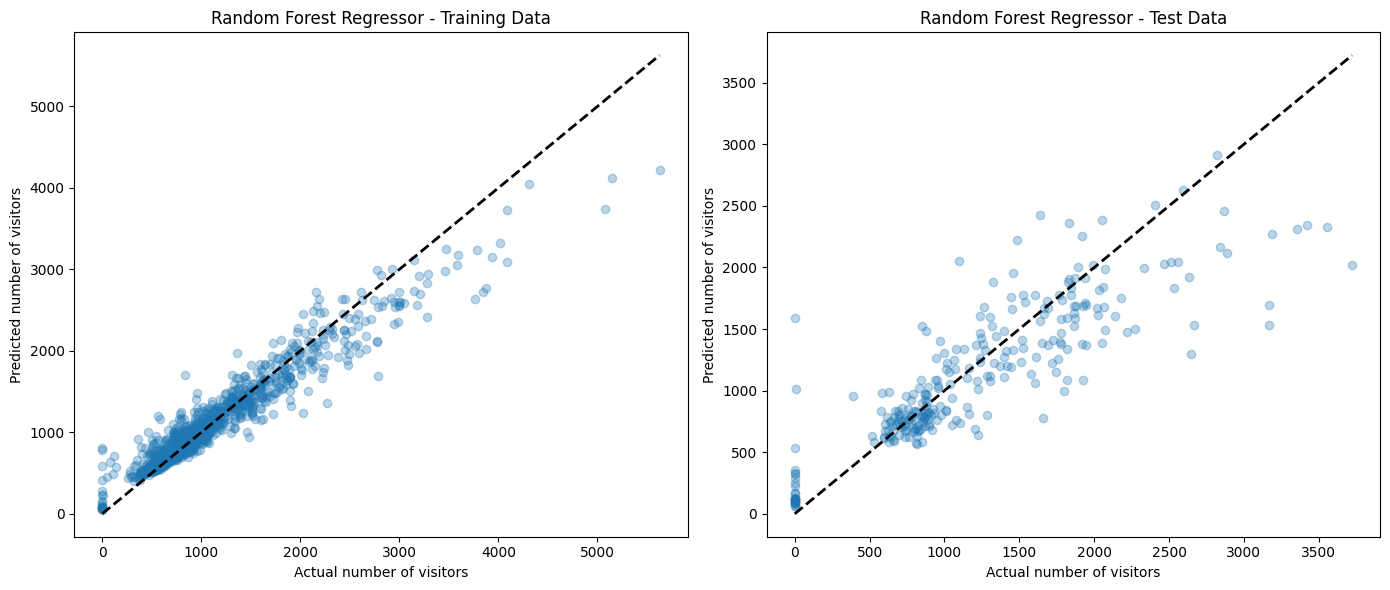

In [443]:
# Setup figure
plt.figure(figsize=(14, 6))

# Plotting the training data predictions
plt.subplot(1, 2, 1)
plt.scatter(y_train, pred_train_rf, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Random Forest Regressor - Training Data')

# Plotting the test data predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, pred_test_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Random Forest Regressor - Test Data')

# Some layout updates
plt.tight_layout()
plt.show()

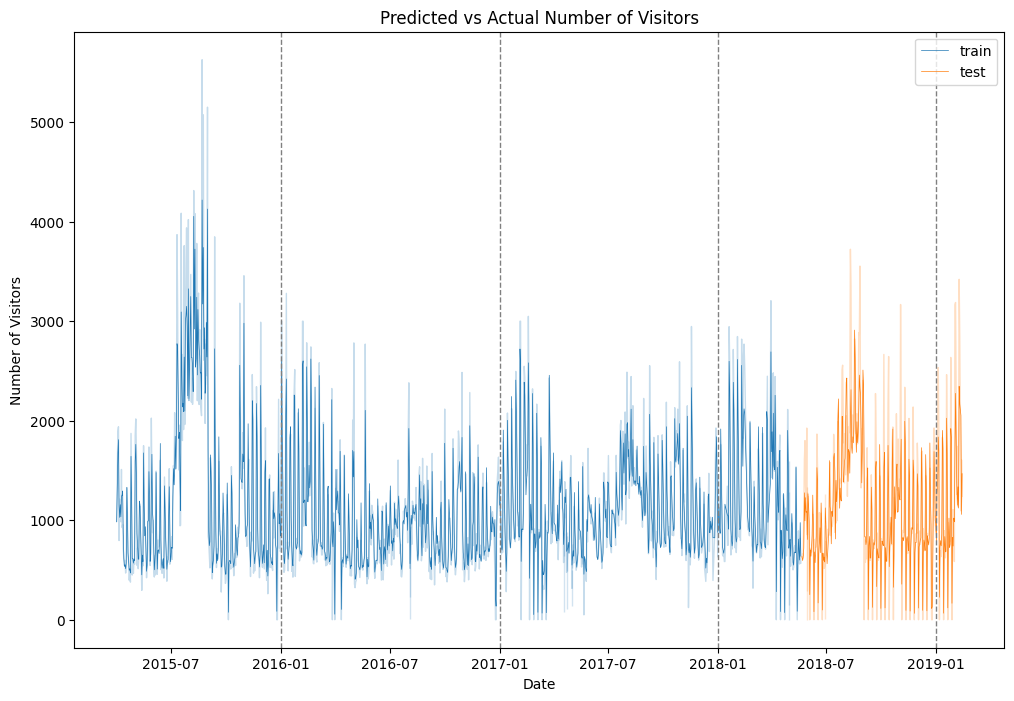

In [444]:
import seaborn as sns

df1 = pd.DataFrame({'date': df_final.loc[id_train, 'Date'], 'pred': pred_train_rf, 'actual': y_train, 'type': 'train'})

df2 = pd.DataFrame({'date': df_final.loc[id_test, 'Date'], 'pred': pred_test_rf, 'actual': y_test, 'type': 'test'})

# df2 = pd.DataFrame({'pred': pred_test_rf, 'actual': y_test})

# pd.DataFrame({'pred': pred_train_rf, 'actual': y_train}).plot()

df = pd.concat([df1, df2], axis=0)

# g = sns.FacetGrid(df, col='type', height=4, aspect=1.5)
# g.map(sns.lineplot, 'date', 'pred', color='red', label='Predicted', linewidth=1)
# g.map(sns.lineplot, 'date', 'actual', color='blue', label='Actual', linewidth=0.5)

sns.lineplot(data=df, x='date', y='pred', hue='type', linewidth=0.5, alpha=1, legend=True)
sns.lineplot(data=df, x='date', y='actual', hue='type', linewidth=1, alpha=0.25, legend=False)

plt.gcf().set_size_inches(12, 8)

# Plots
# df_final.plot(x='Date', y='Number_of_visitors', lw=0.5, figsize=(12,8), kind='line')
# plt.plot(df_final['Date'], df_final['predicted_visitors'], lw=0.5, color='red', linestyle='--')

# Optionally limit to a time range
# plt.xlim(pd.to_datetime('2018-08-01'), pd.to_datetime('2018-08-31'))

# Add a legend
# plt.legend(['Actual', 'Predicted'])

# Add vertical lines at new years
for year in range(2016, 2020):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)

plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.title('Predicted vs Actual Number of Visitors')

plt.legend(loc='upper right')
# df.head()

# print(np.mean(np.abs((y_test - pred_test_rf) / y_test)) * 100)

# sqrt(np.mean(y_test - pred_test_rf)**2)
# 

plt.savefig('figs/visitors_testing.png', dpi=300)


In [474]:
# pd.DataFrame({'pred': pred_test_rf, 'actual': y_test}).plot()

# X_test

# df = df_final.loc[id_test]
df = pd.DataFrame({'pred': pred_test_rf, 'actual': y_test})

df_nozero = df[df['actual'] != 0]

MAPE = np.mean(np.abs((df_nozero['actual'] - df_nozero['pred']) / df_nozero['actual'])) * 100
print(f'MAPE: {MAPE:.4f}%')

MAE = np.mean(np.abs(df['actual'] - df['pred']))
print(f'MAE: {MAE:.4f}')
# problem bc zeroes

RMSE = sqrt(np.mean((df2['actual'] - df2['pred'])**2))
print(f'RMSE: {RMSE:.4f}')

# MAPE = (1/n) * Σ(| (y_actual - y_predicted) / y_actual |) * 100% 

# MAPE = (sum((df2['actual'] - df2['pred']) / df2['actual']) / len(df2)) * 100
# print(MAPE)

# Calculate and print R^2 score
# r2_score(df['actual'], df['pred'])
# print(f"R^2 score: {r2}")

# df_final.loc[id_test].plot(x='Date', y='Number_of_visitors', lw=0.5, figsize=(20,8))
# Plotting the predicted number of visitors
# plt.plot(df_final.loc[id_test, 'Date'], pred_test_rf, lw=0.5, label='Predicted')

# Adding legend
# plt.legend()


MAPE: 199.7387%
MAE: 258.3560
RMSE: 389.0115


### Training

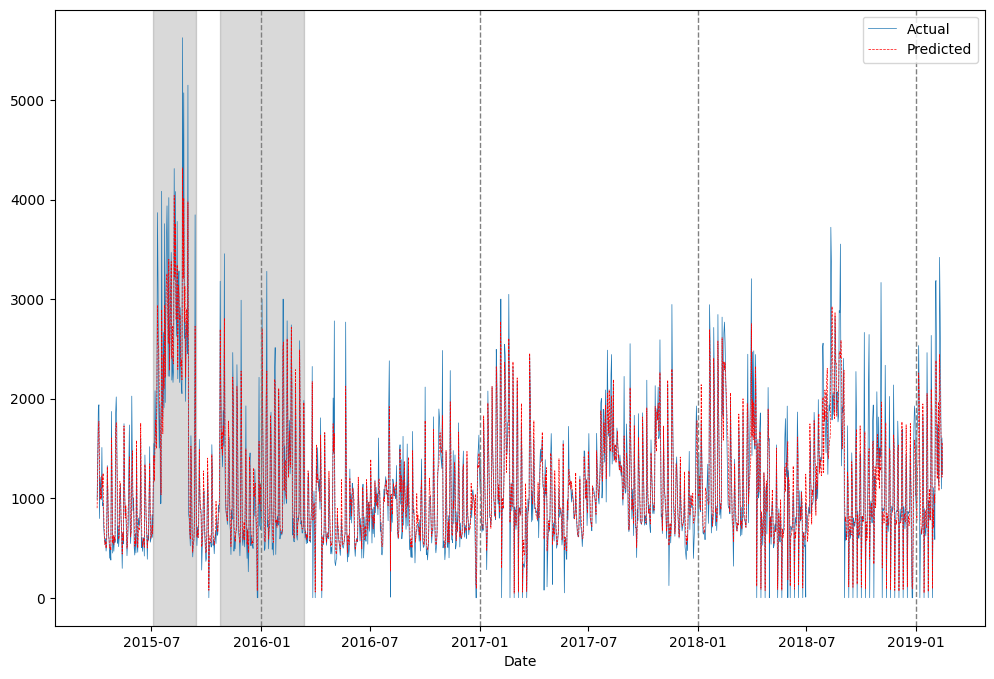

In [324]:
# Plot actual and predicted values

# Get predictions and add to the main data set
df_final['predicted_visitors'] = model_rf.predict(df_final[X_test.columns])

# Plots
df_final.plot(x='Date', y='Number_of_visitors', lw=0.5, figsize=(12,8), kind='line')
plt.plot(df_final['Date'], df_final['predicted_visitors'], lw=0.5, color='red', linestyle='--')

# Optionally limit to a time range
# plt.xlim(pd.to_datetime('2018-08-01'), pd.to_datetime('2018-08-31'))

# Add a legend
plt.legend(['Actual', 'Predicted'])

# Add vertical lines at new years
for year in range(2016, 2020):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)

# Add shaded box for range of dates
axes = plt.gcf().get_axes()
for ax in axes:
    ax.axvspan(pd.to_datetime('2015-10-24'), pd.to_datetime('2016-03-13'), color='black', alpha=0.15) # death: the human experience
    ax.axvspan(pd.to_datetime('2015-07-04'), pd.to_datetime('2015-09-13'), color='black', alpha=0.15) # art forms in nature exhibit

plt.savefig('figs/visitors_training.png', dpi=300)



### Summarize model

In [447]:
# Best day for visitor numbers

feature_names = X_test.columns

# df_final.sort_values('Number_of_visitors', ascending=False)[feature_names].head()

maxValueIndex = df_final['Number_of_visitors'].idxmax(axis=0)
minValueIndex = df_final['Number_of_visitors'].idxmin(axis=0)

rowMax = df_final.loc[[maxValueIndex]][feature_names]
rowMin = df_final.loc[[minValueIndex]][feature_names]

In [448]:
maxdate = df_final.loc[maxValueIndex].Date.strftime('%Y-%m-%d')
mindate = df_final.loc[minValueIndex].Date.strftime('%Y-%m-%d')

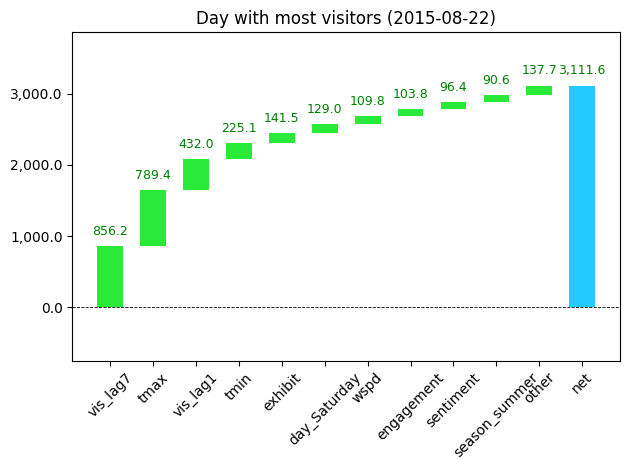

In [452]:
# figure out what's going on using waterfall charts

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall
import warnings

warnings.filterwarnings('ignore', module='waterfall_chart')

# Max values waterfall plot
row = rowMax
prediction, bias, contributions = treeinterpreter.predict(model_rf, row.values)

fig = waterfall(X_test.columns, contributions[0], threshold=0.1, 
          rotation_value=45, formatting='{:,.1f}', sorted_value=True,
          Title="Day with most visitors" + f" ({maxdate})")

fig.savefig('figs/waterfall_max.png', dpi=300)


In [453]:
# bias
# contributions

row
# row.values, row.columns

# TODO: modify waterfall plot function to allow a change in baseline
# TODO: add a function to plot the waterfall plot that gives effect direction

,weekend,exhibit,promotion,sentiment,engagement,closed,prcp,tmin,tmax,wspd,...,day_Thursday,day_Friday,day_Saturday,day_Sunday,season_spring,season_summer,season_autumn,season_winter,vis_lag1,vis_lag7
141,True,True,0.0,0.05,6.0,False,0.002,14.9,27.8,24.1,...,False,False,True,False,False,True,False,False,2051.0,3143.0


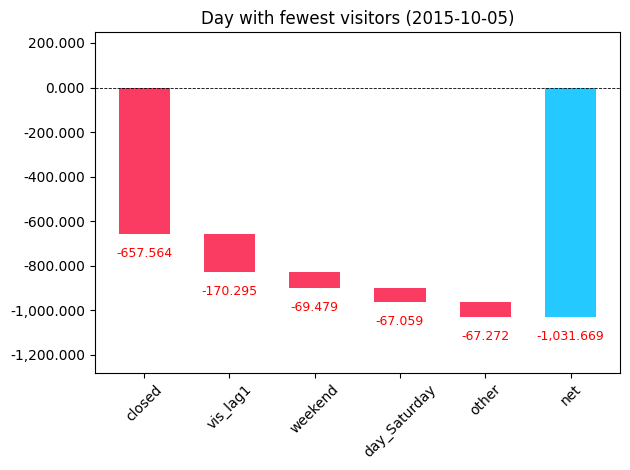

In [454]:
# Min values waterfall plot
row = rowMin
prediction, bias, contributions = treeinterpreter.predict(model_rf, row.values)
fig = waterfall(X_test.columns, contributions[0], threshold=0.1, 
          rotation_value=45, formatting='{:,.3f}', sorted_value=True,
          Title="Day with fewest visitors" + f" ({mindate})")

fig.savefig('figs/waterfall_min.png', dpi=300)

In [455]:
# see if ther are any gaps in days
df_final.Date.diff().dt.days.value_counts()
# this shows that there are 36 2-day gaps and 16 0-day gaps (??)
# NB: might need to fix this above since I'm using row lags

Date
1.0    1312
2.0      42
0.0      19
3.0       2
4.0       2
5.0       1
Name: count, dtype: int64

In [456]:
# Looking at where the zeros come from
merged_data_clim[merged_data_clim['Number_of_visitors'] == 0].groupby('day').size()
# most are Mondays, looking online that's when the museum is often closed (but not always as seen in the time series above)

day
Friday        1
Monday       38
Saturday      1
Sunday        2
Thursday      1
Tuesday       1
Wednesday     1
dtype: int64

#### Look at RF decision tree

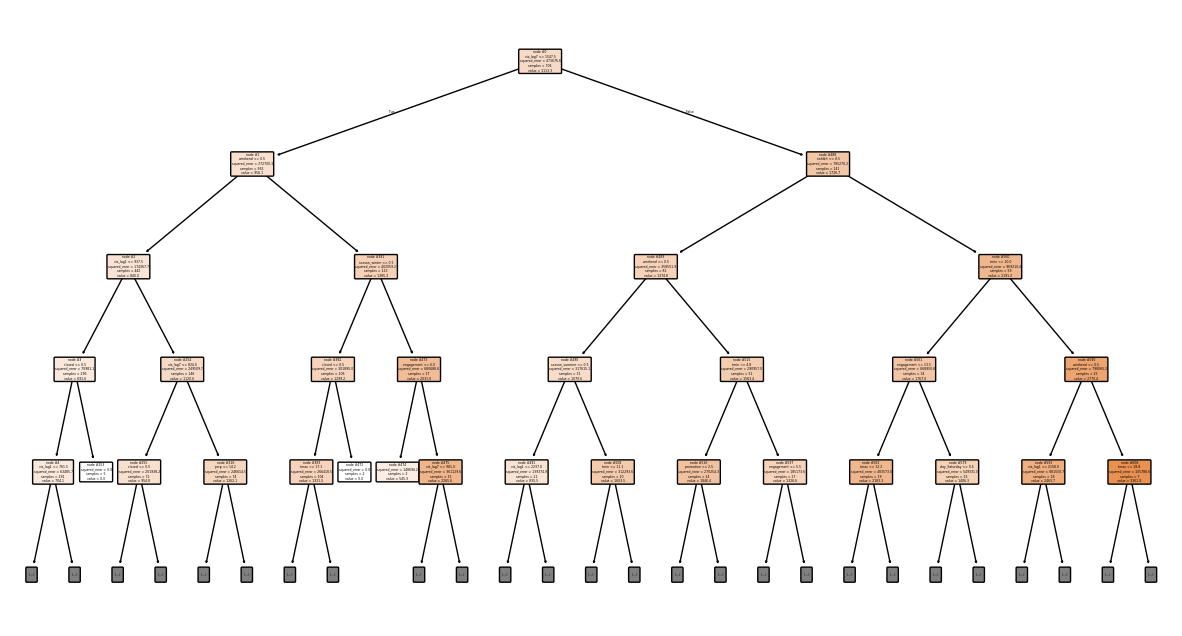

In [457]:
from sklearn import tree

# import pybaobabdt

# Get the feature names
feature_names = X_train.columns

# Pick the first tree from the forest
dtree1 = model_rf.estimators_[0]

# Plot the tree
plt.figure(figsize=(15, 8))
tree.plot_tree(dtree1, feature_names=feature_names, max_depth=4, filled=True, node_ids=True, rounded=True, precision=1)

# text_representation = tree.export_text(dtree1, feature_names=feature_names)
# print(text_representation)

plt.savefig('figs/tree.png', dpi=600)

# Another way
# m = dtreeviz.model(dtree1, X_train, y_train, feature_names=feature_names, target_name='Number_of_visitors')
# m.view(depth_range_to_display=[0,1,2])


#### Get feature importances

In [458]:
importances = model_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

          Feature  Importance
21       vis_lag1    0.260180
22       vis_lag7    0.185891
15   day_Saturday    0.085317
0         weekend    0.064033
8            tmax    0.054652
7            tmin    0.044982
6            prcp    0.043338
9            wspd    0.043167
4      engagement    0.034083
5          closed    0.032426
3       sentiment    0.025811
1         exhibit    0.025510
20  season_winter    0.023396
2       promotion    0.021666
10     day_Monday    0.016965
18  season_summer    0.016402
16     day_Sunday    0.004408
11    day_Tuesday    0.003958
17  season_spring    0.003776
12  day_Wednesday    0.002948
19  season_autumn    0.002767
13   day_Thursday    0.002164
14     day_Friday    0.002161


In [463]:
# range of visitors per day
df_final['Number_of_visitors'].min(), df_final['Number_of_visitors'].max()

(np.float64(0.0), np.float64(5628.0))

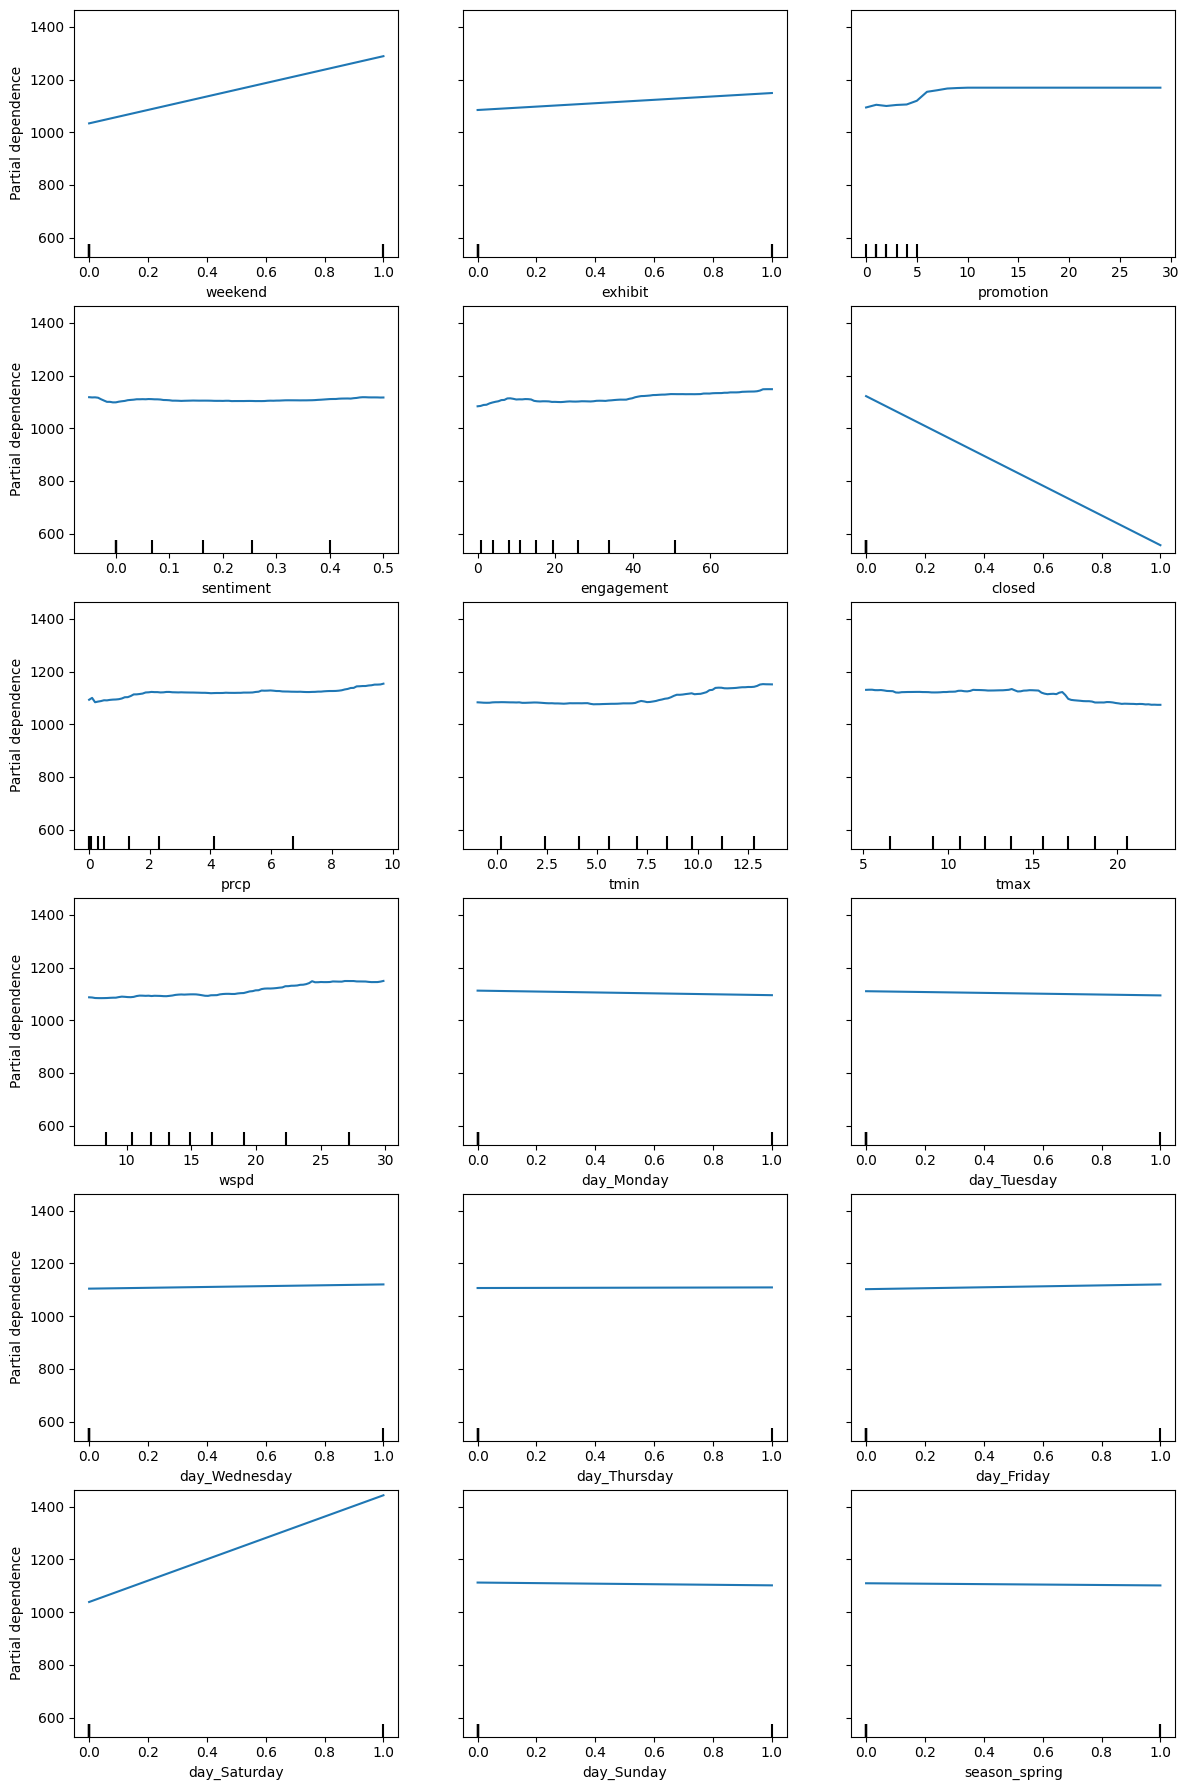

In [466]:
# Partial dependence plots (very cool)
fig = PartialDependenceDisplay.from_estimator(model_rf, X_train, range(18)).figure_
fig.set_figwidth(12)
fig.set_figheight(18)
fig.tight_layout()

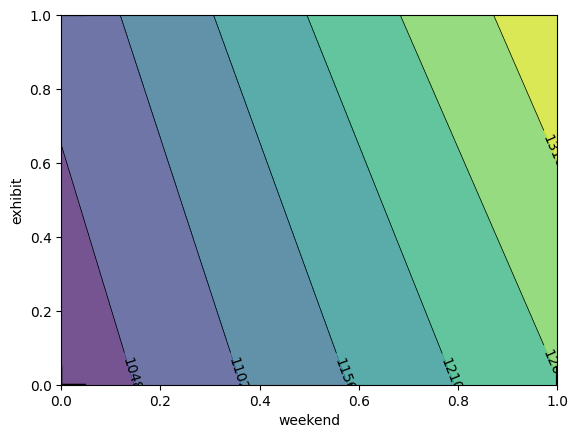

In [467]:
# print(X_train.columns)
fig = PartialDependenceDisplay.from_estimator(model_rf, X_train, [('weekend', 'exhibit')]).figure_
fig.savefig('figs/pdp_weekend.png', dpi=300)

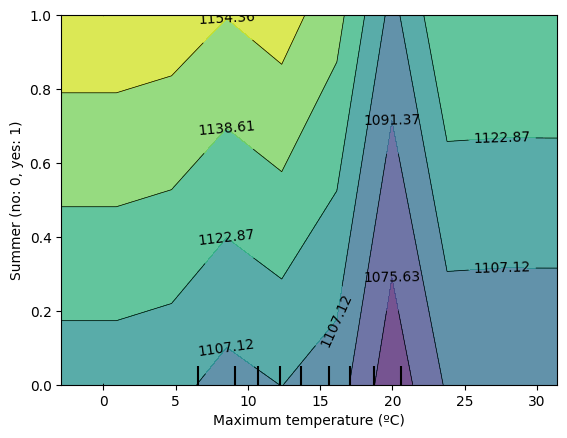

In [468]:
PartialDependenceDisplay.from_estimator(model_rf, X_train, [('tmax', 'season_summer')],
                                        percentiles=(0,1), grid_resolution=10)

# change axis titles
ax = plt.gca()
ax.set_xlabel('Maximum temperature (ºC)')
ax.set_ylabel('Summer (no: 0, yes: 1)')

plt.savefig('figs/pdp_summer_tmax.png', dpi=300)

Text(0, 0.5, 'Spring (no: 0, yes: 1)')

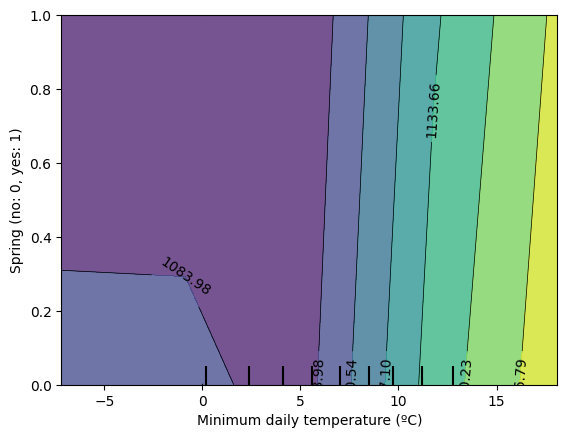

In [469]:
PartialDependenceDisplay.from_estimator(model_rf, X_train, [('tmin', 'season_spring')],
                                        centered=False, kind='average', percentiles=(0, 1),
                                        grid_resolution=5)

# change axis titles
ax = plt.gca()
ax.set_xlabel('Minimum daily temperature (ºC)')
ax.set_ylabel('Spring (no: 0, yes: 1)')


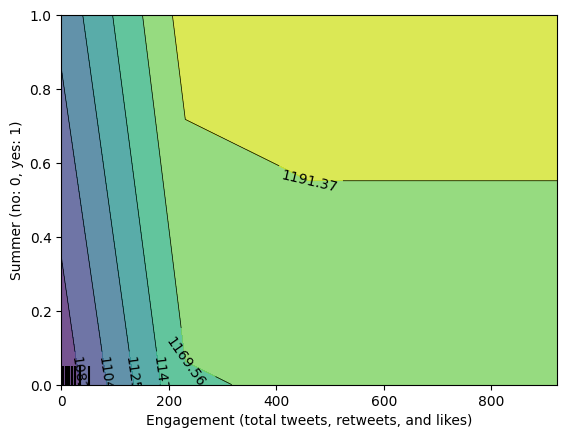

In [480]:
PartialDependenceDisplay.from_estimator(model_rf, X_train, [('engagement', 'season_summer')],
                                        centered=False, kind='average', percentiles=(0, 1),
                                        grid_resolution=5)

# change axis titles
ax = plt.gca()
ax.set_xlabel('Engagement (total tweets, retweets, and likes)')
ax.set_ylabel('Summer (no: 0, yes: 1)')
plt.savefig('figs/pdp_summer_engagement.png', dpi=300)

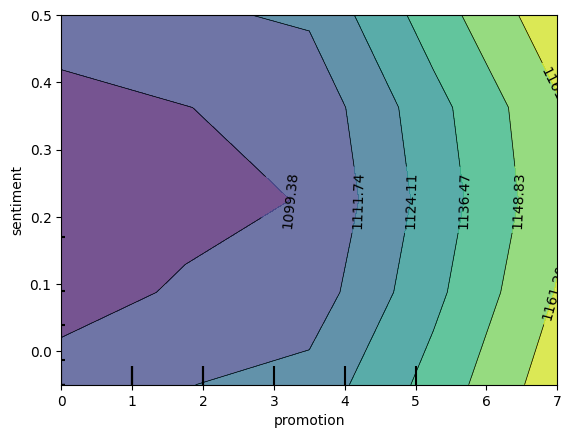

In [488]:
PartialDependenceDisplay.from_estimator(model_rf, X_train, [('promotion', 'sentiment')], grid_resolution=5)


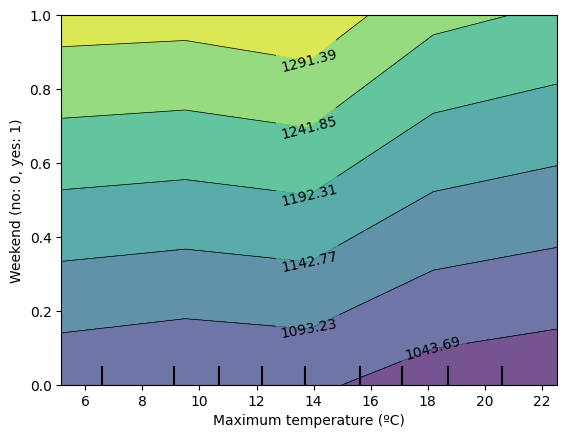

In [471]:
PartialDependenceDisplay.from_estimator(model_rf, X_train, [('tmax', 'weekend')], grid_resolution=5).figure_

# change axis titles
ax = plt.gca()
ax.set_xlabel('Maximum temperature (ºC)')
ax.set_ylabel('Weekend (no: 0, yes: 1)')

plt.savefig('figs/pdp_weekend_tmax.png', dpi=300)
# PartialDependenceDisplay.from_estimator(model_rf, X_train, [('promotion', 'exhibit')])

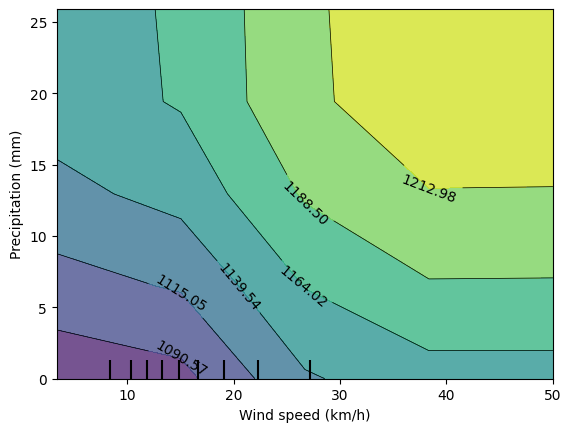

In [472]:
PartialDependenceDisplay.from_estimator(model_rf, X_train, [('wspd', 'prcp')],
                                        centered=False, kind='average', percentiles=(0, 1),
                                        grid_resolution=5).figure_

# change axis titles
ax = plt.gca()
ax.set_xlabel('Wind speed (km/h)')
ax.set_ylabel('Precipitation (mm)')

plt.savefig('figs/pdp_wspd_prcp.png', dpi=300)


np.float64(29.0)

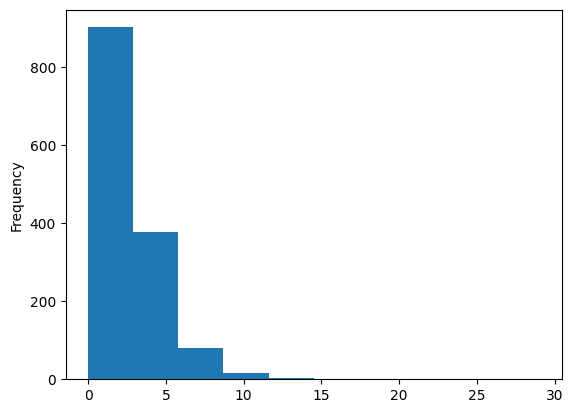

In [105]:
df_final['promotion'].plot(kind='hist')
df_final['promotion'].max()

## Predicting revenue for 2025

In [106]:
# Done!
# Export stuff? Maybe packages used?

# Calculate average temps, precips by year

# make numeric day number of the year column
df_final['dayofyear'] = df_final['date'].dt.dayofyear
df_final['dayofyear']

#

# df = df_final[df_final['year'] == 2015]
# df.head()

df = df_final[df_final.date.dt.year == 2018]
df.head()
len(df)

df_final.Number_of_visitors.groupby(df_final.date.dt.year).sum()

# tmp = df_final.groupby('dayofyear').agg({'tmax':'mean', 'tmin':'mean', 'prcp':'mean', 'wspd':'mean'})
# tmp.reset_index(inplace=True)
# tmp.plot(x='dayofyear', y=['tmax','tmin','prcp','wspd'], subplots=True, layout=(2,2), figsize=(10,10))

# tmp.head()

# selected_columns


date
2015.0    346438.0
2016.0    323527.0
2017.0    361862.0
2018.0    399959.0
2019.0     55659.0
Name: Number_of_visitors, dtype: float64